In [170]:
import soundfile as sf
from glob import glob
import numpy as np
from itertools import combinations
import math,os
from tqdm import tqdm
from scipy.io import wavfile
from scipy import io
from matplotlib import pyplot as plt


# In[2]:


micPos = [[0.0420,0.0615 ,-0.0410],
          [-0.0420,0.0615,0.0410],
          [-0.0615,0.0420,-0.0410],
          [-0.0615,-0.0420,0.0410],
          [-0.0420,-0.0615,-0.0410],
          [0.0420,-0.0615,0.0410],
          [0.0615,-0.0420,-0.0410],
          [0.0615,0.0420,0.0410]]


paramArgs = {'c':343
             ,'fftSize_sec':0.064
             ,'pooling':'max'
             ,'azBound':[-179,181]
             ,'elBound':[-90,11]
             ,'gridRes':1
             ,'alphaRes':5
             ,'minAngle':10
             ,'fs':44100
             ,'micPos':np.transpose(micPos)
             ,'wlen':4096
            }

read_wav = lambda x: sf.read(x)[0]

class ParameterStruct:
    def __init__(self,**args):
        for key in args.keys():
            setattr(self,key,args[key])
        self.setGrids()
        self.setFreq()
        
    def setGrids(self):
        self.azimuth = np.arange(*self.azBound,self.gridRes)
        self.elevation = np.arange(*self.elBound,self.gridRes)
        self.azimuthGrid = np.repeat(self.azimuth.reshape(1,-1),len(self.elevation),0).reshape(-1)
        self.elevationGrid = self.elevation.repeat(len(self.azimuth))
        
    def setFreq(self):
        self.f = self.fs/self.wlen*np.arange(1,(self.wlen/2)+1)

parameters = ParameterStruct(**paramArgs)  

def stft_multi(x,wlen=1024):
    x = x.transpose()
    nchan,nsampl=x.shape
    if nsampl%(wlen/2) != 0:  nsampl = np.floor(nsampl/wlen*2)*wlen/2; x = x[:,:int(nsampl)];
    win = np.sin(np.arange(.5,wlen+.5)/wlen*np.pi)
    nfram = nsampl/wlen*2-1
    nbin = int(wlen/2+1)
    startSample = np.arange(nfram-1)*wlen/2
    endSample = np.arange(nfram-1)*wlen/2 + wlen
    X = np.zeros((int(nbin),int(nfram),nchan),dtype=np.complex)
    for i in range(nchan):
        for t in range(int(nfram)):
            frame=x[i,int(np.ceil(t*wlen/2)):int(np.ceil(t*wlen/2+wlen))]*win
            fframe=np.fft.fft(frame);
            X[:,t,i]=fframe[:nbin];
    return X[1:,]

def polar2cart(args):
    r,az,elev = args
    z = r*math.sin(elev);
    rcoselev = r*math.cos(elev);
    x = rcoselev*math.cos(az);
    y = rcoselev*math.sin(az);

    return x,y,z

def aggregate(parameters):
    micPos = parameters.micPos.transpose()
    thetaGrid = parameters.azimuthGrid
    nDirection = len(thetaGrid)
    nMic = 8
    pairId = np.array(list(combinations(list(range(8)),2)))
    nMicPair = len(pairId)
    pfMn1n2 = micPos[pairId[:,0],:] - micPos[pairId[:,1],:]
    dMic = np.sqrt(np.sum(pfMn1n2**2,1)).reshape(-1,1)
    polar = list(zip(np.ones(len(parameters.azimuthGrid)),parameters.azimuthGrid*np.pi/180,parameters.elevationGrid*np.pi/180))
    Pjk = np.array(list(map(polar2cart,polar))).transpose()
    Pjk_All = np.repeat(np.expand_dims(Pjk,-1),28,-1).transpose(0,2,1)
    Mn1n2_All = np.repeat(np.expand_dims(pfMn1n2.transpose(),-1),nDirection,-1)
    alpha = np.real(np.arccos(np.sum(Pjk_All*Mn1n2_All,0)/np.repeat(dMic,nDirection,-1))*180/np.pi)
    c = parameters.c
    alphaRes = parameters.alphaRes
    alphaSampled = []
    tauGrid = []
    for index in range(nMicPair):
        alphaSampled.append(np.arange(np.floor(min(alpha[index,:])/alphaRes)*alphaRes,np.ceil(max(alpha[index,:])/alphaRes)*alphaRes+1,alphaRes))
        tauGrid.append(dMic[index]*np.cos(alphaSampled[index]*np.pi/180)/c)

    alphaSampled = np.array(alphaSampled)
    tauGrid = np.array(tauGrid)
    return [pairId, dMic, alpha, alphaSampled, tauGrid]

def phatSpec(X,f,tauGrid):
    X1 = X[:,:,0];
    X2 = X[:,:,1];

    nbin,nFrames = X1.shape;
    ngrid = len(tauGrid);

    P = X1*np.conjugate(X2);
    P = P/np.abs(P);
    
    spec = np.zeros((nbin,nFrames,ngrid))
    
    for pkInd in range(ngrid):
        EXP = np.repeat(np.exp(-2*1j*np.pi*tauGrid[pkInd]*parameters.f).reshape(-1,1),nFrames,1)
        spec[:,:,pkInd] = np.real(P)*np.real(EXP) - np.imag(P)*np.imag(EXP)
    return spec

def interp1q(x,y,xi):
    yi = np.zeros((len(xi),y.shape[-1]))
    for col in range(y.shape[-1]):
        yi[:,col] = np.interp(xi,x,y[:,col])
    return yi
        
pairId, dMic, alpha, alphaSampled, tauGrid = aggregate(parameters)

def gccPhat(X,f,tauGrid,pairId,speeds):
    nPairs = 28
    _,nFrames,_ = X.shape
    specInst = np.zeros((len(parameters.azimuthGrid),nFrames))
    idx=np.ones(2048)
    
    for speed in speeds:
        for sp in range(int(speed),int(speed*5),int(speed)):
            iidx=np.logical_not(np.logical_and(np.uint16(parameters.f)>=int(sp)-10,np.uint16(parameters.f)<=int(sp)+10))
            idx=np.logical_and(iidx,idx)
            
    for i in range(nPairs):
        spec = phatSpec(X[:,:,pairId[i]],f,tauGrid[i])
#         print(spec.shape)
        specSampledgrid = np.sum(spec[idx],0).transpose()
        specCurrentPair = interp1q(alphaSampled[i],specSampledgrid,alpha[i])
        specInst += specCurrentPair
    return specInst,spec

def findPeaks2D(ppfSpec,parameters):
    iNbThetas = len(parameters.azimuth)
    iNbPhis = len(parameters.elevation)
    ppf = ppfSpec.reshape(iNbThetas,iNbPhis)
    ppfPadpeakFilter = np.ones((ppf.shape[0]+2,ppf.shape[1]+2))*-np.inf
    ppfPadpeakFilter[1:-1,1:-1] = ppf
    
    arrays = [ppfPadpeakFilter[1:-1,1:-1] >= ppfPadpeakFilter[:-2,1:-1],
          ppfPadpeakFilter[1:-1,1:-1] >= ppfPadpeakFilter[2:,1:-1],
          ppfPadpeakFilter[1:-1,1:-1] >= ppfPadpeakFilter[1:-1,:-2],
          ppfPadpeakFilter[1:-1,1:-1] >= ppfPadpeakFilter[1:-1,2:],
          ppfPadpeakFilter[1:-1,1:-1] >= ppfPadpeakFilter[:-2,:-2],
          ppfPadpeakFilter[1:-1,1:-1] >= ppfPadpeakFilter[:-2,2:],
          ppfPadpeakFilter[1:-1,1:-1] >= ppfPadpeakFilter[2:,:-2],
          ppfPadpeakFilter[1:-1,1:-1] >= ppfPadpeakFilter[2:,2:]
         ]
    
    ppiPeaks = np.ones_like(ppfPadpeakFilter[1:-1,1:-1] >= ppfPadpeakFilter[:-2,1:-1])
    for arr in arrays:
        ppiPeaks = np.logical_and(ppiPeaks,arr)

    iNbLocalmaxima = sum(sum(ppiPeaks));
    ppfSpec2d_peaks = (ppf - min(np.min(ppf,0)))*ppiPeaks
    
    pfSpec1D_peaks = ppfSpec2d_peaks.reshape(-1)
    
    index = np.where(pfSpec1D_peaks==max(np.sort(pfSpec1D_peaks)))
    
    azimuth,elevation = parameters.azimuthGrid[index][0],parameters.elevationGrid[index][0]
    
    return azimuth,elevation,index

return_indexes = lambda x:int(x.split('\\')[-1].split('_')[0].replace('Motor',''))

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

azimuth -45.00 and elevation -21.00 for flight flight timestamp 1
azimuth -45.00 and elevation -21.00 for flight flight timestamp 2
azimuth -50.00 and elevation -20.00 for flight flight timestamp 3
azimuth -51.00 and elevation -20.00 for flight flight timestamp 4
azimuth -55.00 and elevation -20.00 for flight flight timestamp 5
azimuth -56.00 and elevation -20.00 for flight flight timestamp 6
azimuth -65.00 and elevation -18.00 for flight flight timestamp 7
azimuth -69.00 and elevation -20.00 for flight flight timestamp 8
azimuth -69.00 and elevation -20.00 for flight flight timestamp 9
azimuth -79.00 and elevation -21.00 for flight flight timestamp 10
azimuth -80.00 and elevation -21.00 for flight flight timestamp 11
azimuth -80.00 and elevation -21.00 for flight flight timestamp 12
azimuth -84.00 and elevation -21.00 for flight flight timestamp 13
azimuth -90.00 and elevation -19.00 for flight flight timestamp 14
azimuth -92.00 and elevation -20.00 for flight flight timestamp 15
accu

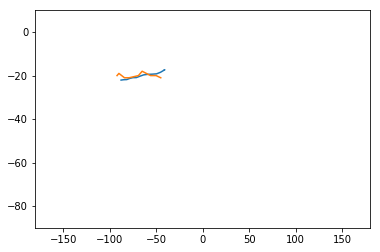

 50%|██████████████████████████████████████████                                          | 1/2 [00:54<00:54, 54.60s/it]

azimuth -122.00 and elevation -18.00 for flight flight timestamp 1
azimuth -121.00 and elevation -18.00 for flight flight timestamp 2
azimuth -117.00 and elevation -20.00 for flight flight timestamp 3
azimuth -117.00 and elevation -19.00 for flight flight timestamp 4
azimuth -110.00 and elevation -20.00 for flight flight timestamp 5
azimuth -103.00 and elevation -21.00 for flight flight timestamp 6
azimuth -92.00 and elevation -22.00 for flight flight timestamp 7
azimuth -85.00 and elevation -21.00 for flight flight timestamp 8
azimuth -78.00 and elevation -21.00 for flight flight timestamp 9
azimuth -77.00 and elevation -21.00 for flight flight timestamp 10
azimuth -61.00 and elevation -23.00 for flight flight timestamp 11
azimuth -61.00 and elevation -22.00 for flight flight timestamp 12
azimuth -56.00 and elevation -23.00 for flight flight timestamp 13
azimuth -47.00 and elevation -21.00 for flight flight timestamp 14
azimuth -46.00 and elevation -22.00 for flight flight timestamp 1

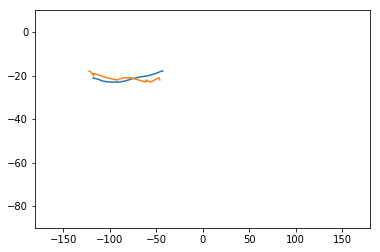

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:35<00:00, 68.56s/it]


In [173]:
if __name__ == '__main__':
    type_ = 'flight'
#     noise_root=r'G:\spcup\data\individual_motors_recordings'
#     singlePaths = list(filter(lambda x:'\\Motor' in x,glob(os.path.join('%s'%noise_root,'*.wav'))))
#     allMotorPath = list(filter(lambda x:'\\allMotor' in x,glob(os.path.join('%s'%noise_root,'*.wav'))))
    
#     paths = glob(r'G:\spcup\SPCUP19-master\dev_%s\audio\*.wav'%type_)
    db=-5
    paths=glob('notunShobKhela/all_motor_70_flight/*%d*.wav'%db)[-2:]
#     paths=glob(flightPaths+os.sep+'audio/speech'+os.sep+'*.wav')
    path__=glob(r'G:\spcup\SPCUP19-master\dev_%s\*.mat'%type_)[0]
    
    trueAz=io.loadmat(path__)['broadband_azimuth']
    trueEl=io.loadmat(path__)['broadband_elevation']
    
    speeds=io.loadmat(glob(flightPaths+os.sep+'*.mat')[0])['speech_flight_motor_speed']
    #     paths=glob(r'result*.wav')
    
    
    start = int(44.1*1e3*6)
    end = int(44.1*1e3*17)
    
    if type_ == 'flight': slices = [(slice(int(0.25*i*44100),int((0.25*i+0.5)*44100)),slice(0,8)) for i in range(15)]
    else: slices = [(slice(0,97020),slice(0,8))]
        
    for path in tqdm(paths,total=len(paths)):        
        audio = read_wav(path)
        totalScore=0
        azs=[];els=[]
        for idx,index in enumerate(slices):
            x = audio[index]
            X = stft_multi(x,parameters.wlen)
#             speed=speeds[int(path.split(os.sep)[-1].replace('.wav',''))-1]
            specInst,spec = gccPhat(X,parameters.f,tauGrid,pairId,np.array([75,75,75,75]))
            if parameters.pooling == 'max': specGlobal = np.max(specInst,1)
            elif parameters.pooling == 'sum': specGlobal = np.sum(specInst,1)

            azimuth,elevation,_ = findPeaks2D(specGlobal,parameters)
            
            azs.append(azimuth)
            els.append(elevation)
            currentScoreAz = np.abs(azimuth-trueAz[int(path.split(os.sep)[-1].split('_')[-2])-1][idx])<=10
            currentScoreEl = np.abs(elevation-trueEl[int(path.split(os.sep)[-1].split('_')[-2])-1][idx])<=10
            
            if currentScoreAz and currentScoreEl:
                totalScore+=1
            
            print('azimuth %.2f and elevation %.2f for %s %s timestamp %d'%(azimuth,elevation,type_,path.split(os.sep)[-2].split('_')[-1],idx+1))

        print('accuracy is %.3f'%(100*totalScore/15))
        plt.plot(trueAz[int(path.split(os.sep)[-1].split('_')[-2])-1],trueEl[int(path.split(os.sep)[-1].split('_')[-2])-1])
        plt.plot(np.array(azs),np.array(els))
        plt.xlim([-180,180])
        plt.ylim([-90,10])
        plt.show()